# ARIMA Anomaly Detection using Monthly Average Daily Pressure Signals from the WD Dataset
This notebook demonstrates the application of the auto_arima() function for detecting anomalies in monthly average daily pressure signals from the Weather Dataset.

The code in this notebook is based on a tutorial from the pmdarima GitHub repository: https://github.com/alkaline-ml/pmdarima/blob/master/examples/stock_market_example.ipynb.

In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import pmdarima as pm
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from sklearn.metrics import mean_squared_error
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.metrics import smape



/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5024/2738741400.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
#from subprocess import check_output
#import seaborn as sns
#import warnings
#from statsmodels.tsa.arima_model import ARIMA

## Data preprocessing
First, read the 'daily pressure.csv' file from the 'data' folder, and then calculate the average monthly pressure.

In [3]:
#read 'daily_pressure_Bamberg.csv' data
df = pd.read_csv('data/daily_pressure_Bamberg.csv')

#convert the 'MESS_DATUM' column to a datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])
df.set_index('MESS_DATUM', inplace=True)

#resample the DataFrame by month ('M') and calculate the mean for each month
df = df.resample('M').mean()
df.head()


,P
MESS_DATUM,
1961-01-31,1018.027742
1961-02-28,1023.624643
1961-03-31,1024.453871
1961-04-30,1010.609000
1961-05-31,1014.762581


In [4]:
#reset the index of the DataFrame 'df' and store the result in 'df_monthly_mean'
df_monthly_mean = df.reset_index(drop=False)
df_monthly_mean.head()

,MESS_DATUM,P
0,1961-01-31,1018.027742
1,1961-02-28,1023.624643
2,1961-03-31,1024.453871
3,1961-04-30,1010.609000
4,1961-05-31,1014.762581


Set a new format for the index column as MM-YYYY and save it in a new CSV file.

In [5]:
df_monthly_mean['MESS_DATUM'] = pd.to_datetime(df_monthly_mean['MESS_DATUM'])
df_monthly_mean['Date'] = df_monthly_mean['MESS_DATUM'].dt.strftime('%Y-%m')
df_monthly_mean.drop(columns=['MESS_DATUM'], inplace=True)
df_monthly_mean.set_index('Date', inplace=True)

In [6]:
df_monthly_mean.to_csv('data/Monthly_pressure_ARIMA.csv',index=True)

## Plots
Create plots of rolling mean and seasonal value decomposition. Create lag plot.

In [7]:
#read 'Monthly_pressure_ARIMA.csv' as DataFrame
df_monthly_mean = pd.read_csv('data/Monthly_pressure_ARIMA.csv',index_col=0)

In [8]:
# define the window size for the rolling mean calculation
window_size = 12  # Set the window size to 12 months

# calculate the rolling mean of the 'P' column
df_monthly_mean['Rolling_Mean'] = df_monthly_mean['P'].rolling(window=window_size).mean()

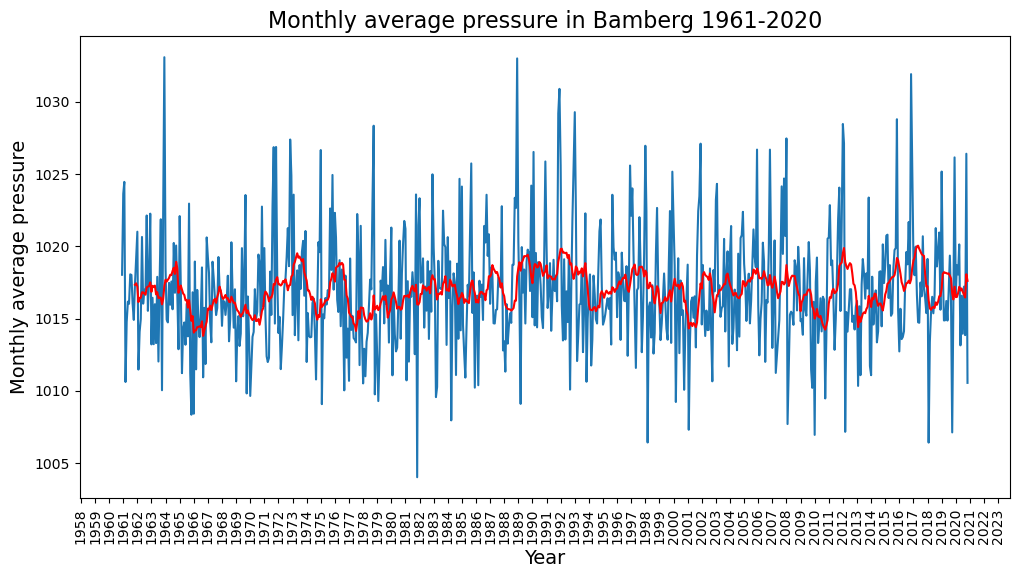

In [9]:
# convert the index of the DataFrame 'df_monthly_mean' to datetime format
df_monthly_mean.index = pd.to_datetime(df_monthly_mean.index)

# plot
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_mean.index, df_monthly_mean['P'])# plot the Monthly average pressure over time
plt.plot(df_monthly_mean.index, df_monthly_mean['Rolling_Mean'], 
        label=f'Rolling mean (window={window_size})', color='red') #plot the rolling mean
plt.xlabel('Year',size=14)
plt.ylabel('Monthly average pressure',size=14)
plt.title('Monthly average pressure in Bamberg 1961-2020',size=16)


#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)
plt.xticks(rotation=90)


plt.show()


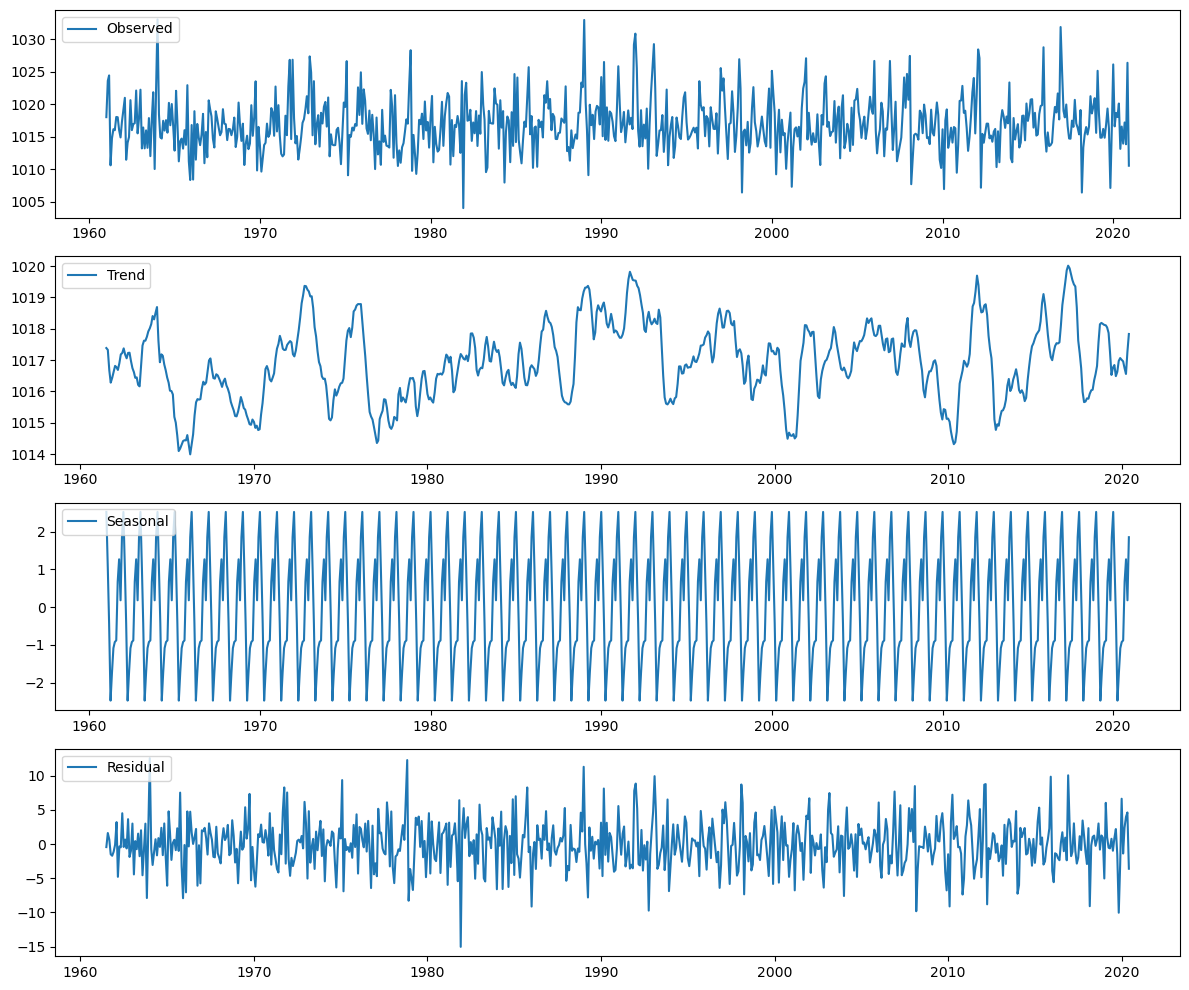

In [10]:
# Perform seasonal decomposition
result = seasonal_decompose(df_monthly_mean['P'], model='additive', period=12)  #additive model
#result = seasonal_decompose(df_monthly_mean['P'], model='multiplicative', period=12) #multiplicative model
# Plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [11]:
# Generate a summary of df_monthly_mean
df_monthly_mean.describe()

,P,Rolling_Mean
count,720.000000,709.000000
mean,1016.951694,1016.945892
std,4.037313,1.222011
min,1004.019677,1013.801917
25%,1014.516276,1016.135066
50%,1016.528983,1016.905623
75%,1019.044548,1017.797126
max,1033.079032,1020.041797


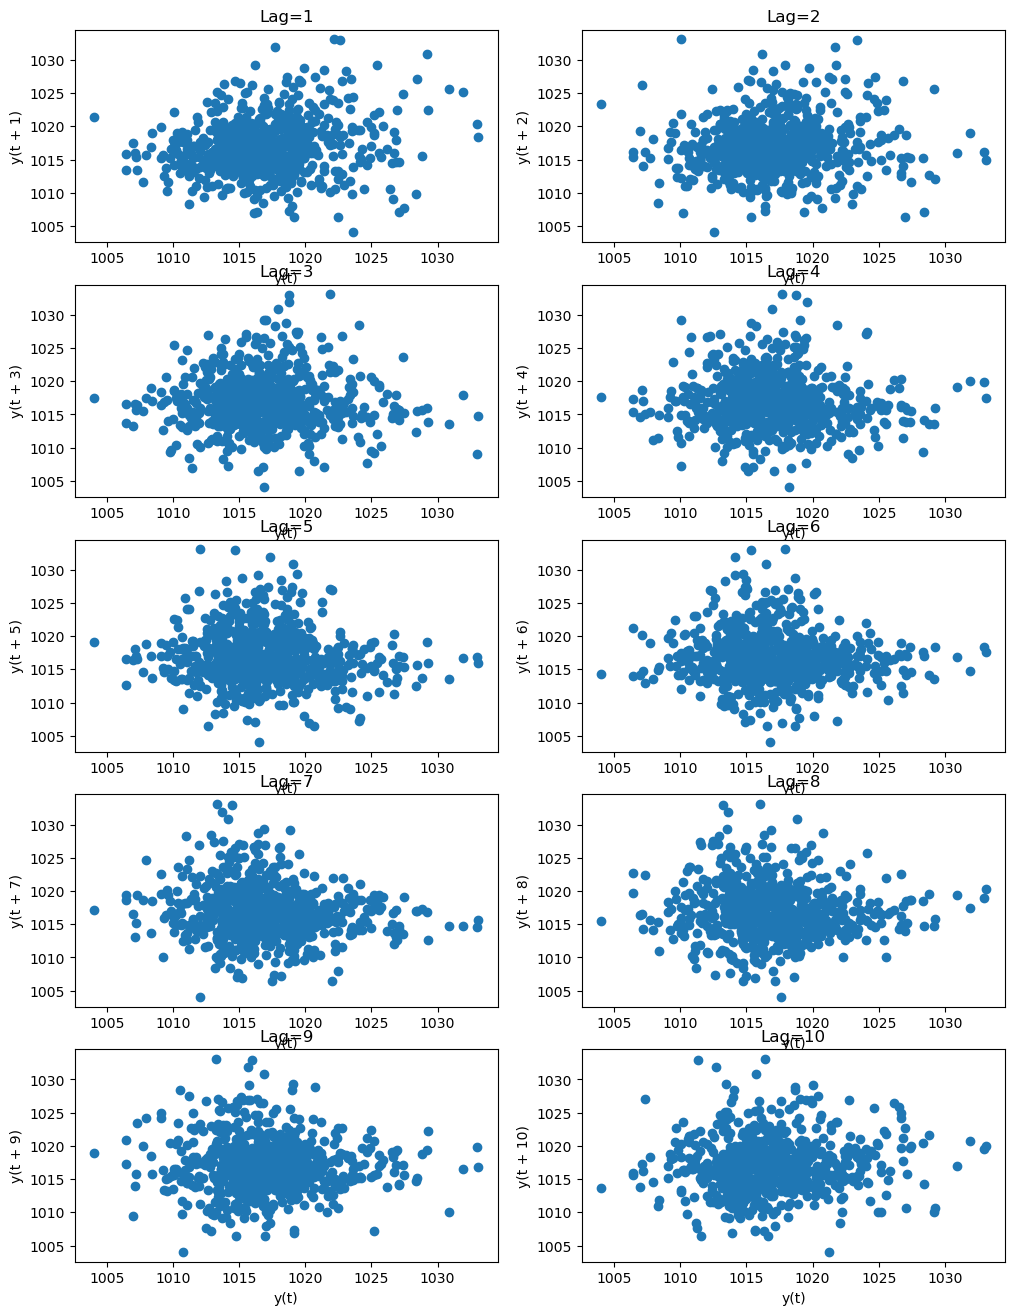

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1),
    (3,0),
    (3,1),
    (4,0),
    (4,1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df_monthly_mean['P'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

## ARIMA
1. Split the data into training and test sets.
2. Choose the best ARIMA model using pm.auto_arima.
3. Make predictions with the chosen model.
4. Define anomaly points.

In [13]:
#80% refers to training data, 20% refers to test data
#train_len = int(df_monthly_mean.shape[0] * 0.8)
#train_data, test_data = df_monthly_mean[:train_len], df_monthly_mean[train_len:]
#print(f"{train_len} train samples")
#print(f"{df.shape[0] - train_len} test samples")

#values from 1961 to 2000 belong to the training data, and from 2001 to 2020 belong to the test data.
train_data, test_data = df_monthly_mean[df_monthly_mean.index.year <= 2000], df_monthly_mean[df_monthly_mean.index.year > 2000]
y_train = train_data['P'].values
y_test = test_data['P'].values
print(f"{len(y_train)} train samples")
print(f"{df.shape[0] - len(y_train)} test samples")

480 train samples
240 test samples


In [14]:
# set seasonal to True
seasonal = True

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2692.827, Time=2.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2708.513, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2687.016, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8011.706, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2701.801, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2689.053, Time=1.55 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2687.685, Time=1.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2689.685, Time=4.89 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2690.826, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2687.779, Time=1.57 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=2684.906, Time=0.43 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=2697.407, Time=0.13 sec
 ARIMA(0,0,2)(1,0,1)[12] inte

In [15]:
# set seasonal to False
seasonal = False

# use pmdarima to automatically select best ARIMA model
model_ns = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model_ns.summary())

/Users/anastasiasinitsyna/anaconda3/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8011.706, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2728.397, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2724.314, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2725.423, Time=0.51 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2748.774, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2701.014, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2701.734, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2698.657, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2700.089, Time=0.06 s

In [16]:
#based on signal properties and AIC of models from previous steps
model = model
#model = model_ns
#define a function for one-step ahead forecasting
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    #use the 'forecast_one_step' function to obtain the forecast and confidence intervals
    fc, conf = forecast_one_step()
    #append the forecast and confidence intervals to their respective lists
    forecasts.append(fc)
    confidence_intervals.append(conf)
    #updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
#calculate Mean Squared Error (MSE) and Symmetric Mean Absolute Percentage Error (SMAPE)
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 15.72394847296064
SMAPE: 0.28768586526987305


In [17]:
#add forecast to test data
test_data['forecast'] = forecasts

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5024/342429525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast'] = forecasts


In [18]:
test_data.head()

,P,Rolling_Mean,forecast
Date,,,
2001-01-01,1016.391290,1015.504730,1017.467538
2001-02-01,1018.727857,1015.260212,1017.550371
2001-03-01,1007.303871,1014.311959,1017.339342
2001-04-01,1013.425667,1014.662015,1014.556160
2001-05-01,1016.187097,1014.704166,1015.553371


In [25]:
train_data.head()

,P,Rolling_Mean
Date,,
1961-01-01,1018.027742,NaN
1961-02-01,1023.624643,NaN
1961-03-01,1024.453871,NaN
1961-04-01,1010.609000,NaN
1961-05-01,1014.762581,NaN


In [19]:
#anomaly detection
#calculate the squared error for each data point by subtracting 'forecast' from 'P' and squaring the result
test_data['squared_error'] = np.square(test_data['P'] - test_data['forecast'])

#calculate the Mean Squared Error (MSE) and Standard Deviation (STD) of squared errors
mean_squared_error = test_data['squared_error'].mean()
std_squared_error = test_data['squared_error'].std()

#set a multiplier 'z'
z = 2.0 

#calculate the threshold value for identifying anomalies
threshold = mean_squared_error + (z * std_squared_error)

#identify anomalies based on squared errors and add an 'is_anomaly' column
test_data['is_anomaly'] = (test_data['squared_error'] >= threshold).astype(int)

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5024/41334386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['squared_error'] = np.square(test_data['P'] - test_data['forecast'])
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5024/41334386.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['is_anomaly'] = (test_data['squared_error'] >= threshold).astype(int)


In [20]:
#print amount of anomalies
print(sum(test_data['is_anomaly']))

15


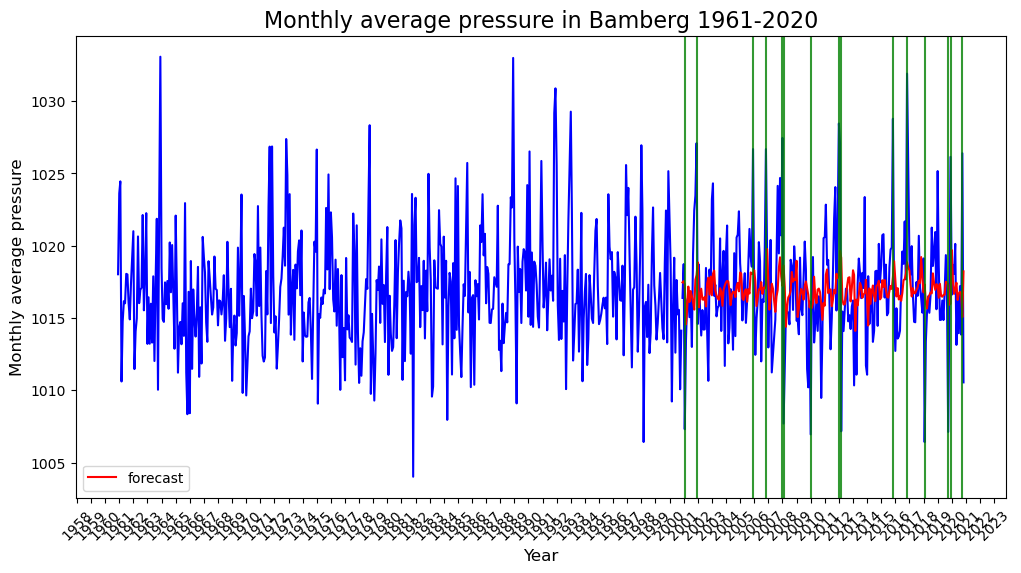

In [21]:
#convert the indices of 'test_data' and 'train_data' DataFrames to datetime format
test_data.index = pd.to_datetime(test_data.index)
train_data.index = pd.to_datetime(train_data.index)


plt.figure(figsize=(12, 6))
#plot the monthly average pressure
plt.plot(train_data.index, train_data['P'],color='blue')
plt.plot(test_data.index, test_data['P'],color='blue')
#plot the forecast
plt.plot(test_data.index, test_data['forecast'], label=f'forecast', color='red')

plt.xlabel('Year',size=12)
plt.ylabel('Monthly average pressure',size=12)
plt.title('Monthly average pressure in Bamberg 1961-2020',size=16)

#identify the indices of anomalies
anomaly_indices = test_data.index[test_data['is_anomaly'] == 1]

#create vertical lines for anomaly points, marked in green
for anomaly_index in anomaly_indices:
    plt.axvline(x=anomaly_index, color='green', alpha=0.8)

#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [22]:
#save results as csv data
test_data.to_csv('data/Monthly_pressure_anomaly_ARIMA_results_test2001.csv')

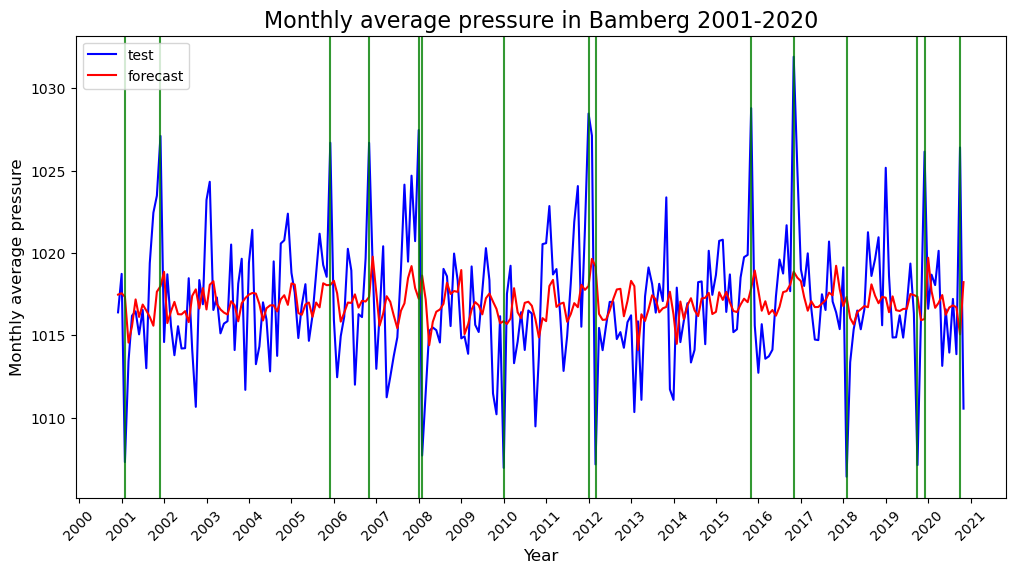

In [24]:
#convert the index of 'train_data' DataFrames to datetime format
test_data.index = pd.to_datetime(test_data.index)

plt.figure(figsize=(12, 6))
#plot the monthly average pressure
plt.plot(test_data.index, test_data['P'],color='blue', label='test')
#plot the forecast
plt.plot(test_data.index, test_data['forecast'], label='forecast', color='red')
plt.xlabel('Year',size=12)
plt.ylabel('Monthly average pressure',size=12)
plt.title('Monthly average pressure in Bamberg 2001-2020',size=16)

#identify the indices of anomalies
anomaly_indices = test_data.index[test_data['is_anomaly'] == 1]

#create vertical lines for anomaly points, marked in green
for anomaly_index in anomaly_indices:
    plt.axvline(x=anomaly_index, color='green', alpha=0.8)

#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=45)
plt.legend()
plt.show()

Pressure experiments with whole dataset and daily average

In [85]:
df = pd.read_csv('daily_pressure_Bamberg.csv')
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])
df.set_index('MESS_DATUM', inplace=True)


In [92]:
window_size = 365  # Задайте размер окна скользящего среднего
df['Rolling_Mean'] = df['P'].rolling(window=window_size).mean()

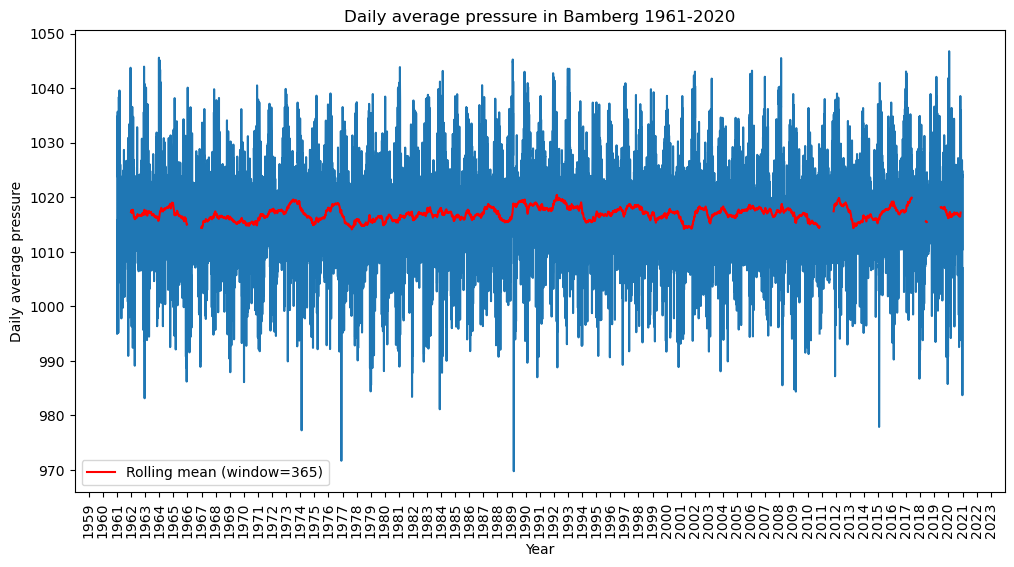

In [93]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
df.index = pd.to_datetime(df.index)
# Постройте график средней температуры за каждый месяц
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['P'])
plt.plot(df.index, df['Rolling_Mean'], label=f'Rolling mean (window={window_size})', color='red')
plt.xlabel('Year')
plt.ylabel('Daily average pressure')
plt.title('Daily average pressure in Bamberg 1961-2020')


# Создайте объекты для форматирования даты
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')

# Установите форматирование для оси x
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [95]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
# Создайте экземпляр SimpleImputer
imp = SimpleImputer()

# Используйте fit_transform для импутации и замены пропущенных значений в столбце 'value'
df['P'] = imp.fit_transform(df[['P']])

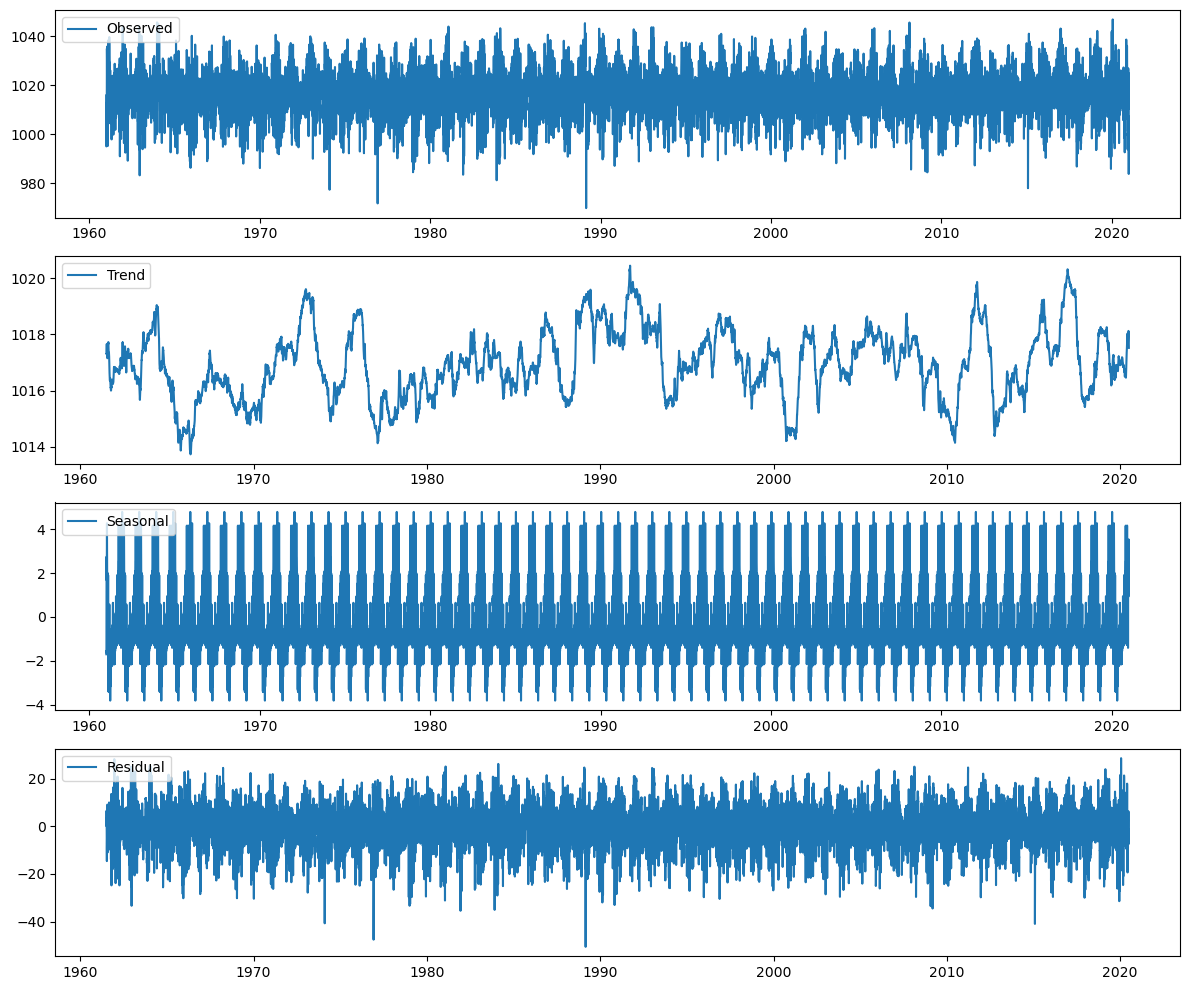

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Perform seasonal decomposition
result = seasonal_decompose(df['P'], model='additive', period=365)  # Adjust the period as needed

# Plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [104]:
# Generate a summary of the DataFrame's statistics, including datetime columns treated as numeric
display(df.describe(include='all', datetime_is_numeric=True))

,P,Rolling_Mean
count,21869.000000,19984.000000
mean,1016.959845,1016.991595
std,8.631660,1.148041
min,969.780000,1014.131863
25%,1011.730000,1016.210233
50%,1016.959845,1016.957274
75%,1022.380000,1017.795753
max,1046.800000,1020.445753


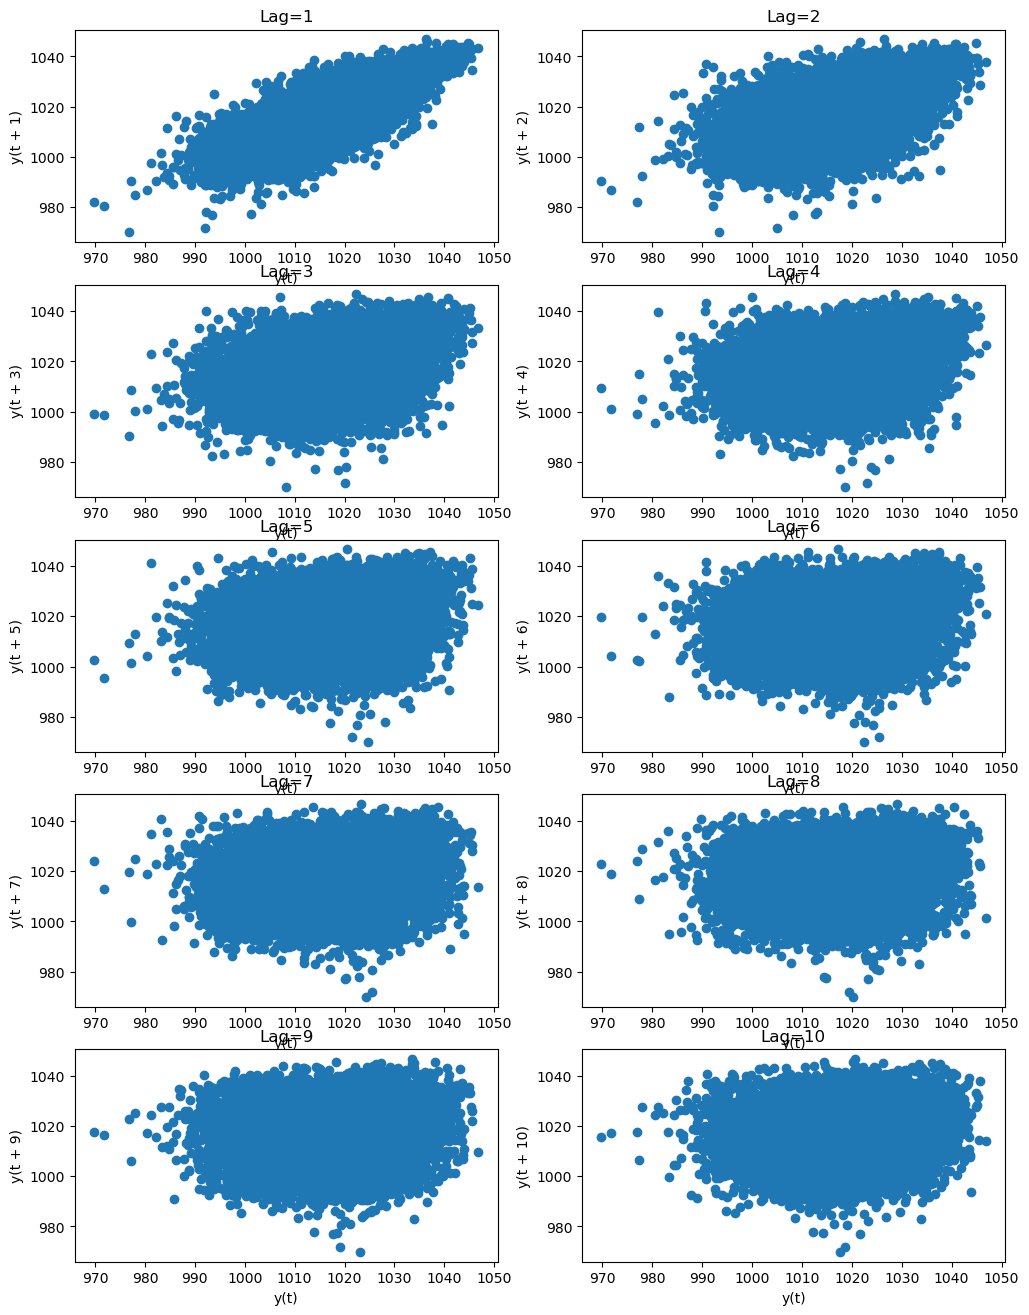

In [106]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(5, 2, figsize=(12, 16))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1),
    (3,0),
    (3,1),
    (4,0),
    (4,1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['P'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

In [107]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['P'].values
y_test = test_data['P'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

17495 train samples
4374 test samples


In [108]:
# import necessary libraries
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# set seasonal to True
seasonal = True

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=40.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=125353.603, Time=0.53 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=112864.761, Time=11.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=291942.553, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=112908.517, Time=2.57 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=57.85 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=112860.897, Time=28.15 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=127.61 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=125247.392, Time=20.05 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=107462.146, Time=147.67 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=107460.280, Time=18.27 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=107458.470, Time=4.48 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=88.79 sec
 ARIMA(1,0,1)(1,

KeyboardInterrupt: 